## Homework 01. Simple text processing.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from IPython import display

### Toxic or not
Your main goal in this assignment is to classify, whether the comments are toxic or not. And practice with both classical approaches and PyTorch in the process.

*Credits: This homework is inspired by YSDA NLP_course.*

*Disclaimer: The used dataset may contain obscene language and is used only as an example of real unfiltered data.*

In [2]:
# In colab uncomment this cell
# ! wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/homeworks/homework01/utils.py -nc

In [3]:
try:
    data = pd.read_csv('comments.tsv', sep='\t')
except FileNotFoundError:
    ! wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/comments_small_dataset/comments.tsv -nc
    data = pd.read_csv("comments.tsv", sep='\t')

In [4]:
texts = data['comment_text'].values
target = data['should_ban'].values
data[50::200]

,should_ban,comment_text
50,0,"""Those who're in advantageous positions are th..."
250,1,Fartsalot56 says f**k you motherclucker!!
450,1,"Are you a fool? \n\nI am sorry, but you seem t..."
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,Citing sources\n\nCheck out the Wikipedia:Citi...


In [5]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

__Note:__ it is generally a good idea to split data into train/test before anything is done to them.

It guards you against possible data leakage in the preprocessing stage. For example, should you decide to select words present in obscene tweets as features, you should only count those words over the training set. Otherwise your algoritm can cheat evaluation.

### Preprocessing and tokenization

Comments contain raw text with punctuation, upper/lowercase letters and even newline symbols.

To simplify all further steps, we'll split text into space-separated tokens using one of nltk tokenizers.

Generally, library `nltk` [link](https://www.nltk.org) is widely used in NLP. It is not necessary in here, but mentioned to intoduce it to you.

In [6]:
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "I don\'t want to do that" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),)

before: How to be a grown-up at work: replace "I don't want to do that" with "Ok, great!".
after: how to be a grown-up at work : replace " i don't want to do that " with " ok , great ! " .


In [7]:
texts_train = [preprocess(text) for text in texts_train]
texts_test = [preprocess(text) for text in texts_test]

In [8]:
# Small check that everything is done properly
assert texts_train[5] ==  'who cares anymore . they attack with impunity .'
assert texts_test[89] == 'hey todds ! quick q ? why are you so gay'
assert len(texts_test) == len(y_test)

### Step 1: bag of words

One traditional approach to such problem is to use bag of words features:
1. build a vocabulary of frequent words (use train data only)
2. for each training sample, count the number of times a word occurs in it (for each word in vocabulary).
3. consider this count a feature for some classifier

__Note:__ in practice, you can compute such features using sklearn. __Please don't do that in the current assignment, though.__
* `from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer`

In [9]:
# task: find up to k most frequent tokens in texts_train,
# sort them by number of occurences (highest first)
k = min(10000, len(set(' '.join(texts_train).split())))

bow_vocabulary = [word for word in set(' '.join(texts_train).split())]

print('example features:', sorted(bow_vocabulary)[::100])

example features: ['!', '12:20', '300', '_', 'adorned', 'alternative', 'archive', 'average', 'benkner', 'bout', 'came', 'chest', 'combined', 'consumers', 'cricket', 'decisions', 'dickheads', 'domestic', 'eductaion', 'essentially', 'faggot', 'firms', 'frustrated', 'goal', 'hanibal', 'hip-hop', 'identified', 'infoboxes', 'issue', 'kindergarten', 'lets', 'lot', "mclaren's", 'moderator', 'naturally', 'noticeable', 'opposing', 'pdf', 'plant', 'pretoria', 'punctuation', 'rebels', 'repetative', 'riadh', 'schulz', 'shes', 'slit', 'spoof', 'stupid', 't', 'theoretical', 'topic', 'uglyness', 'userspace', 'wanted', 'wikieditor', 'year', '←']


In [10]:
def text_to_bow(text):
    """ convert text string to an array of token counts. Use bow_vocabulary. """
    
    bow_vector = [0] * k
    for token in text.split():
        if token in bow_vocabulary:
            bow_vector[bow_vocabulary.index(token)] += 1

    return np.array(bow_vector, 'float32')

In [11]:
X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

In [12]:
# Small check that everything is done properly
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[6, bow_vocabulary.index('.')] == texts_train[6].split().count('.')

Now let's do the trick with `sklearn` logistic regression implementation:

In [13]:
from sklearn.linear_model import LogisticRegression
bow_model = LogisticRegression().fit(X_train_bow, y_train)

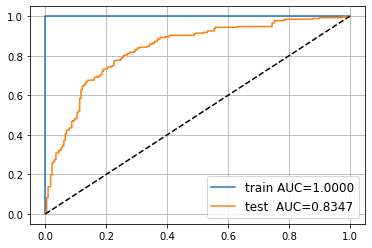

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

for name, X, y, model in [
    ('train', X_train_bow, y_train, bow_model),
    ('test ', X_test_bow, y_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Seems alright. Now let's create the simple logistic regression using PyTorch. Just like in the classwork.

In [15]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

from sklearn.metrics import accuracy_score

In [16]:
from utils import plot_train_process

In [17]:
model_bow_nn_seq = nn.Sequential()

model_bow_nn_seq.add_module('l1', nn.Linear(k, 2))

Remember what we discussed about loss functions! `nn.CrossEntropyLoss` combines both log-softmax and `NLLLoss`.

__Be careful with it! Criterion `nn.CrossEntropyLoss` with still work with log-softmax output, but it won't allow you to converge to the optimum.__ Next comes small demonstration:

In [18]:
# loss_function = nn.NLLLoss()
loss_function = nn.CrossEntropyLoss()

In [19]:
opt = torch.optim.Adam(model_bow_nn_seq.parameters())

In [20]:
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, patience=35)

In [21]:
X_train_bow_torch = torch.tensor(X_train_bow)
X_test_bow_torch = torch.tensor(X_test_bow)

y_train_torch = torch.tensor(y_train)
y_test_torch = torch.tensor(y_test)

Let's test that everything is fine

In [22]:
# example loss
loss = loss_function(model_bow_nn_seq(X_train_bow_torch[:3]), y_train_torch[:3])

In [23]:
assert type(loss.item()) == float

Here comes small function to train the model. In future we will take in into separate file, but for this homework it's ok to implement it here. 

In [24]:
def train_model(
    model,
    opt,
    lr_scheduler,
    X_train_torch,
    y_train_torch,
    X_val_torch,
    y_val_torch,
    n_iterations=500,
    batch_size=32,
    warm_start=False,
    show_plots=True,
    eval_every=10
):
    if not warm_start:
        for name, module in model.named_children():
            print('resetting ', name)
            try:
                module.reset_parameters()
            except AttributeError as e:
                print('Cannot reset {} module parameters: {}'.format(name, e))

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    local_train_loss_history = []
    local_train_acc_history = []
    for i in range(n_iterations):
        
        # clear gradients
        opt.zero_grad()

        # sample 256 random observations
        ix = np.random.randint(0, len(X_train_torch), batch_size)
        x_batch = X_train_torch[ix]
        y_batch = y_train_torch[ix]

        # predict log-probabilities or logits
        y_predicted = model(x_batch)

        # compute loss, just like before
        loss = loss_function(y_predicted, y_batch)
        # compute gradients
        loss.backward()
        # Adam step
        opt.step()


        local_train_loss_history.append(loss.data.numpy())
        local_train_acc_history.append(
            accuracy_score(
                y_batch.to('cpu').detach().numpy(),
                y_predicted.to('cpu').detach().numpy().argmax(axis=1)
            )
        )

        if i % eval_every == 0:
            train_loss_history.append(np.mean(local_train_loss_history))
            train_acc_history.append(np.mean(local_train_acc_history))
            local_train_loss_history, local_train_acc_history = [], []

            predictions_val = model(X_val_torch)
            val_loss_history.append(loss_function(predictions_val, y_val_torch).to('cpu').detach().item())

            acc_score_val = accuracy_score(y_val_torch.cpu().numpy(), predictions_val.to('cpu').detach().numpy().argmax(axis=1))
            val_acc_history.append(acc_score_val)
            lr_scheduler.step(train_loss_history[-1])

            if show_plots:
                display.clear_output(wait=True)
                plot_train_process(train_loss_history, val_loss_history, train_acc_history, val_acc_history)
    return model

Let's run it on the data. Note, that here we use the `test` part of the data for validation. It's not so good idea in general, but in this task our main goal is practice.

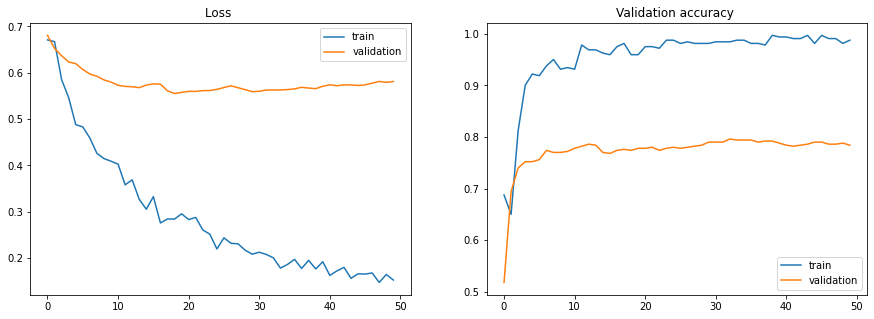

In [25]:
model_nn_bow = train_model(model_bow_nn_seq, opt, lr_scheduler, X_train_bow_torch, y_train_torch, X_test_bow_torch, y_test_torch)

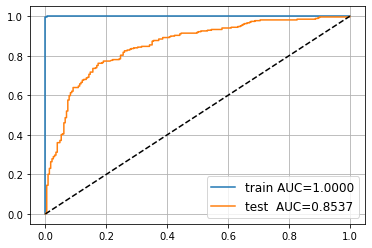

In [26]:
for name, X, y, model in [
    ('train', X_train_bow_torch, y_train_torch, model_nn_bow),
    ('test ', X_test_bow_torch, y_test_torch, model_nn_bow)
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Try to vary the number of tokens `k` and check how the model performance changes. Show it on a plot.

In [27]:
def text_to_bow_new(text):
    
    bow_vector = [0] * k_tokens
    for token in text.split():
        if token in bow_vocabulary_new:
            bow_vector[bow_vocabulary_new.index(token)] += 1

    return np.array(bow_vector, 'float32')

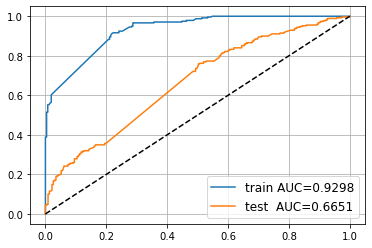

In [28]:
# варьируем значения токенов
k_tokens = 500 
# создаем словарь
bow_vocabulary_new = bow_vocabulary[0:k_tokens]
# применяем преобразования к данным
X_train_bow_new = np.stack(list(map(text_to_bow_new, texts_train)))
X_test_bow_new = np.stack(list(map(text_to_bow_new, texts_test)))
# обучаем Логистическую регрессию
bow_model_new_500 = LogisticRegression().fit(X_train_bow_new, y_train)

for name, X, y, model in [
    ('train', X_train_bow_new, y_train, bow_model_new_500),
    ('test ', X_test_bow_new, y_test, bow_model_new_500)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

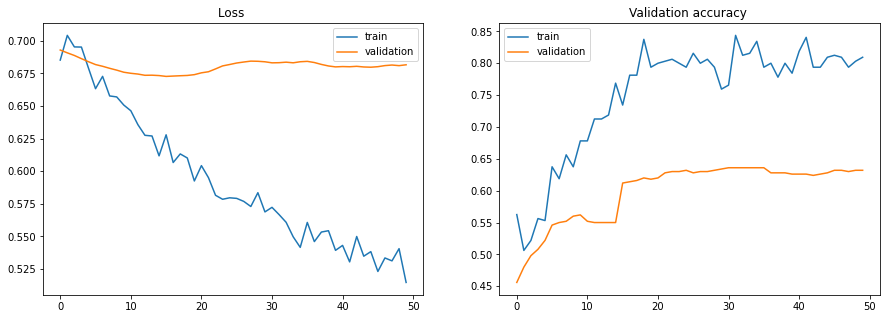

In [29]:
# инициализируем данные для pytorch
X_train_bow_torch_500 = torch.tensor(X_train_bow_new)
X_test_bow_torch_500 = torch.tensor(X_test_bow_new)

y_train_torch = torch.tensor(y_train)
y_test_torch = torch.tensor(y_test)

# посмотрим на реализацию логистической регрессии в Pytorch

# инициализируем модель
model_new_500 = nn.Sequential()
model_new_500.add_module('l1', nn.Linear(k_tokens, 2))
# функция потерь
loss_function = nn.CrossEntropyLoss()
# с
opt = torch.optim.Adam(model_new_500.parameters())
lr_scheduler = ReduceLROnPlateau(opt, patience=35)
model_nn_bow_500 = train_model(model_new_500, opt, lr_scheduler, X_train_bow_torch_500, y_train_torch, X_test_bow_torch_500, y_test_torch)

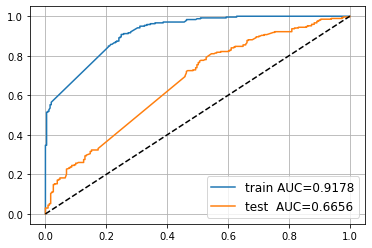

In [30]:
for name, X, y, model in [
    ('train', X_train_bow_torch_500, y_train_torch, model_nn_bow_500),
    ('test ', X_test_bow_torch_500, y_test_torch, model_nn_bow_500)
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

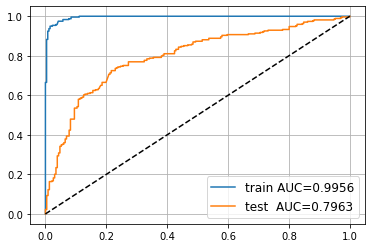

In [31]:
# варьируем значения токенов
k_tokens = 2000
# создаем словарь
bow_vocabulary_new = bow_vocabulary[0:k_tokens]
# применяем преобразования к данным
X_train_bow_new = np.stack(list(map(text_to_bow_new, texts_train)))
X_test_bow_new = np.stack(list(map(text_to_bow_new, texts_test)))
# обучаем Логистическую регрессию
bow_model_new_2000 = LogisticRegression().fit(X_train_bow_new, y_train)

for name, X, y, model in [
    ('train', X_train_bow_new, y_train, bow_model_new_2000),
    ('test ', X_test_bow_new, y_test, bow_model_new_2000)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

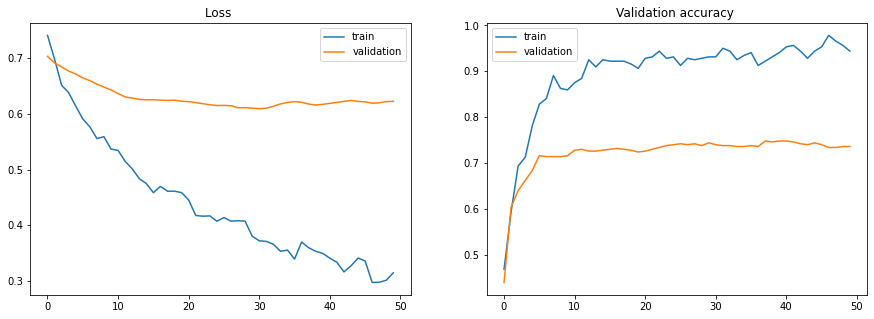

In [32]:
# инициализируем данные для pytorch
X_train_bow_torch_2000 = torch.tensor(X_train_bow_new)
X_test_bow_torch_2000 = torch.tensor(X_test_bow_new)

y_train_torch = torch.tensor(y_train)
y_test_torch = torch.tensor(y_test)

# посмотрим на реализацию логистической регрессии в Pytorch

# инициализируем модель
model_new_2000 = nn.Sequential()
model_new_2000.add_module('l1', nn.Linear(k_tokens, 2))
# функция потерь
loss_function = nn.CrossEntropyLoss()
# с
opt = torch.optim.Adam(model_new_2000.parameters())
lr_scheduler = ReduceLROnPlateau(opt, patience=35)
model_nn_bow_2000 = train_model(model_new_2000, opt, lr_scheduler, X_train_bow_torch_2000, y_train_torch, X_test_bow_torch_2000, y_test_torch)

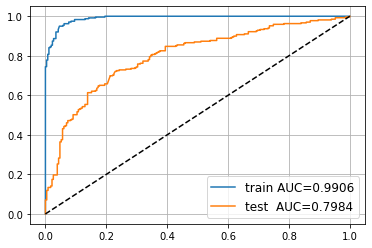

In [33]:
for name, X, y, model in [
    ('train', X_train_bow_torch_2000, y_train_torch, model_nn_bow_2000),
    ('test ', X_test_bow_torch_2000, y_test_torch, model_nn_bow_2000)
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

### Step 2: implement TF-IDF features

Not all words are equally useful. One can prioritize rare words and downscale words like "and"/"or" by using __tf-idf features__. This abbreviation stands for __text frequency/inverse document frequence__ and means exactly that:

$$ feature_i = { Count(word_i \in x) \times { log {N \over Count(word_i \in D) + \alpha} }}, $$


where x is a single text, D is your dataset (a collection of texts), N is a total number of documents and $\alpha$ is a smoothing hyperparameter (typically 1). 
And $Count(word_i \in D)$ is the number of documents where $word_i$ appears.

It may also be a good idea to normalize each data sample after computing tf-idf features.

__Your task:__ implement tf-idf features, train a model and evaluate ROC curve. Compare it with basic BagOfWords model from above.

__Please don't use sklearn/nltk builtin tf-idf vectorizers in your solution :)__ You can still use 'em for debugging though.

Blog post about implementing the TF-IDF features from scratch: https://triton.ml/blog/tf-idf-from-scratch

Same stuff about moel and optimizers here (or just omit it, if you are using the same model as before).

In [34]:
import math

dict_voc = {i: 0 for i in bow_vocabulary}
for txt in texts_train:
    for val in dict_voc.keys():
        if val in txt:
            dict_voc[val] += 1

def tfidf(text, alpha=1):
    
    text_set = set(text.split())
    val_word = {i: 0 for i in text_set}
    for word in text.split():
        val_word[word] += 1
    for word in val_word.keys():
        val_word[word] = val_word[word] / len(text.split())

    tfidf_vector = [0] * len(sorted(bow_vocabulary))
    for i, word in enumerate(sorted(bow_vocabulary)):
        if val_word.get(word, None):
            tfidf_vector[i] = val_word[word] * math.log10(len(texts_train) / (dict_voc[word] + alpha))

    return np.array(tfidf_vector, 'float32')

In [35]:
# преобразуем все данные в tfidf
tfidf_train = np.stack(list(map(tfidf, texts_train)))
tfidf_test = np.stack(list(map(tfidf, texts_test)))

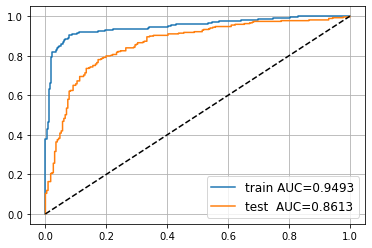

In [36]:
# обучаем Логистическую регрессию
model_tfidf = LogisticRegression().fit(tfidf_train, y_train)

for name, X, y, model in [
    ('train', tfidf_train, y_train, model_tfidf),
    ('test ', tfidf_test, y_test, model_tfidf)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

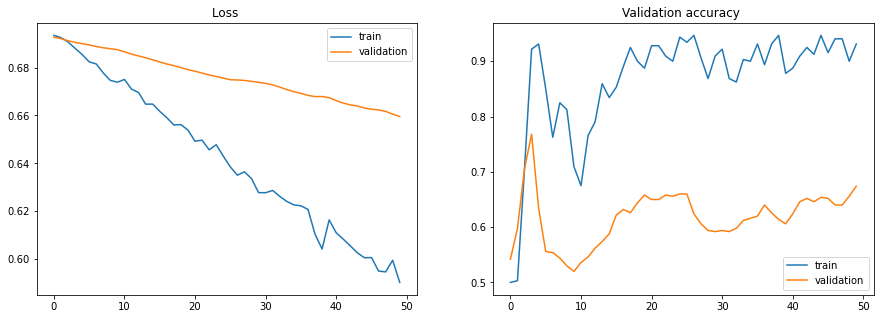

In [37]:
# инициализируем данные для pytorch
X_train_tfidf_torch = torch.tensor(tfidf_train)
X_test_tfidf_torch = torch.tensor(tfidf_test)

y_train_torch = torch.tensor(y_train)
y_test_torch = torch.tensor(y_test)

# посмотрим на реализацию логистической регрессии в Pytorch

# инициализируем модель
model_tf = nn.Sequential()
model_tf.add_module('l1', nn.Linear(len(bow_vocabulary), 2))
# функция потерь
loss_function = nn.CrossEntropyLoss()
# оптимизитор
opt = torch.optim.Adam(model_tf.parameters())
lr_scheduler = ReduceLROnPlateau(opt)
model_nn_tfidf = train_model(model_tf, opt, lr_scheduler, X_train_tfidf_torch, y_train_torch, X_test_tfidf_torch, y_test_torch)

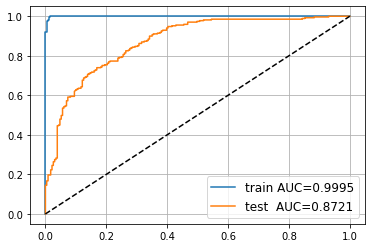

In [38]:
for name, X, y, model in [
    ('train', X_train_tfidf_torch, y_train_torch, model_nn_tfidf),
    ('test ', X_test_tfidf_torch, y_test_torch, model_nn_tfidf)
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Fit your model to the data. No not hesitate to vary number of iterations, learning rate and so on.

_Note: due to very small dataset, increasing the complexity of the network might not be the best idea._

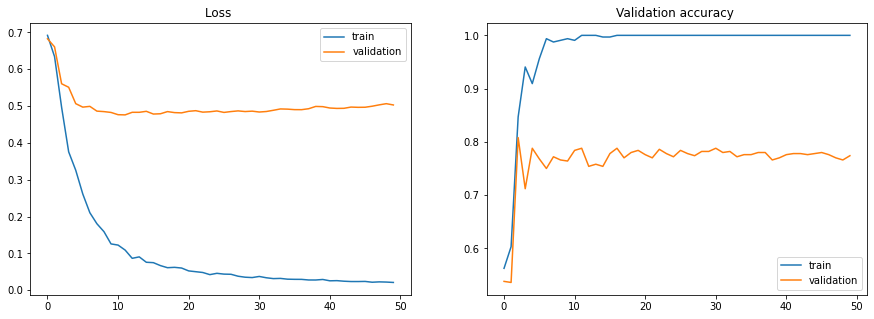

In [39]:
# изменим параметры модели для подгонки к данным

# инициализируем данные для pytorch
X_train_tfidf_torch = torch.tensor(tfidf_train)
X_test_tfidf_torch = torch.tensor(tfidf_test)

y_train_torch = torch.tensor(y_train)
y_test_torch = torch.tensor(y_test)

# посмотрим на реализацию логистической регрессии в Pytorch

# инициализируем модель
model_tf_top = nn.Sequential()
model_tf_top.add_module('l1', nn.Linear(len(bow_vocabulary), 2))
# функция потерь
loss_function = nn.CrossEntropyLoss()
# оптимизитор
opt = torch.optim.AdamW(model_tf_top.parameters(), lr=0.1)
lr_scheduler = ReduceLROnPlateau(opt)
model_nn_tfidf_top = train_model(model_tf_top, opt, lr_scheduler, X_train_tfidf_torch, y_train_torch, X_test_tfidf_torch, y_test_torch, n_iterations=500)

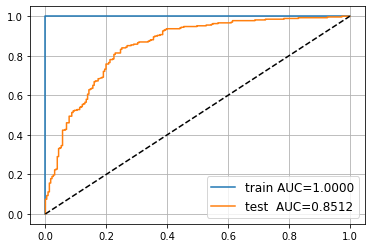

In [40]:
for name, X, y, model in [
    ('train', X_train_tfidf_torch, y_train_torch, model_nn_tfidf_top),
    ('test ', X_test_tfidf_torch, y_test_torch, model_nn_tfidf_top)
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

In [41]:
model_nn_tfidf_top.eval()
_, predicted_nn_tfidf = torch.max(model_nn_tfidf_top(X_test_tfidf_torch), 1)
print(f"Точность топовой модели логистической регрессии на pytorch для TFIDF, accuracy = {accuracy_score(predicted_nn_tfidf, y_test_torch)} и roc_auc = {roc_auc_score(predicted_nn_tfidf, y_test_torch)}")

Точность топовой модели логистической регрессии на pytorch для TFIDF, accuracy = 0.776 и roc_auc = 0.7758524136386182


##### На графиках видно переобучение под train набор и то, что модель model_nn_tfidf_top дала наибольший результат по метрикам

### Step 3: Comparing it with Naive Bayes

Naive Bayes classifier is a good choice for such small problems. Try to tune it for both BOW and TF-iDF features. Compare the results with Logistic Regression.

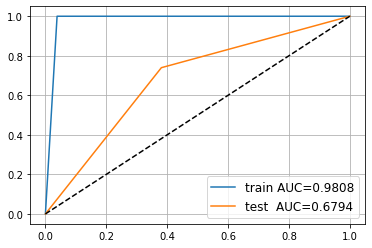

In [42]:
from sklearn.naive_bayes import GaussianNB

# сравним результаты для BOW
model_nb_bow = GaussianNB().fit(X_train_bow, y_train)

for name, X, y, model in [
    ('train', X_train_bow, y_train, model_nb_bow),
    ('test ', X_test_bow, y_test, model_nb_bow)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

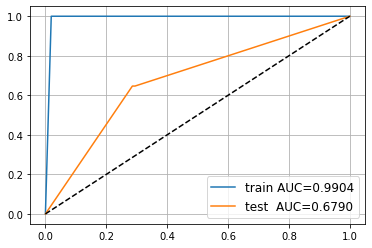

In [43]:
# сравним результаты для tfidf
model_nb_tfidf = GaussianNB().fit(tfidf_train, y_train)

for name, X, y, model in [
    ('train', tfidf_train, y_train, model_nb_tfidf),
    ('test ', tfidf_test, y_test, model_nb_tfidf)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

In [44]:
from sklearn.metrics import accuracy_score, roc_auc_score

# обучим лог регрессию на bow и tfidf
model_log_bow = LogisticRegression().fit(X_train_bow, y_train)
model_log_tfidf = LogisticRegression().fit(tfidf_train, y_train)

# переведем в режим предикт модели
model_nn_bow.eval()
_, predicted_nn_bow = torch.max(model_nn_bow(X_test_bow_torch), 1)
# model_nn_tfidf_top.eval()
# _, predicted_nn_tfidf = torch.max(model_nn_tfidf_top(X_test_tfidf_torch), 1)
# сравним результаты
print(f"""Результаты для метрики accuracy:
- Модель логистической регрессии для BOW, accuracy = {accuracy_score(model_log_bow.predict(X_test_bow), y_test)};
- Модель логистической регрессии для TFIDF, accuracy = {accuracy_score(model_log_tfidf.predict(tfidf_test), y_test)};
- Модель логистической регрессии на pytorch для BOW, accuracy = {accuracy_score(predicted_nn_bow, y_test_torch)};
- Модель логистической регрессии на pytorch для TFIDF, accuracy = {accuracy_score(predicted_nn_tfidf, y_test_torch)};
- Модель Naive Bayes для BOW, accuracy = {accuracy_score(model_nb_tfidf.predict(tfidf_test), y_test)};
- Модель Naive Bayes для TFIDF, accuracy = {accuracy_score(model_nb_bow.predict(X_test_bow), y_test)}\n
Результаты для метрики roc_auc:
- Модель логистической регрессии для BOW, roc_auc = {roc_auc_score(model_log_bow.predict(X_test_bow), y_test)};
- Модель логистической регрессии для TFIDF, roc_auc = {roc_auc_score(model_log_tfidf.predict(tfidf_test), y_test)};
- Модель логистической регрессии на pytorch для BOW, roc_auc = {roc_auc_score(predicted_nn_bow, y_test_torch)};
- Модель логистической регрессии на pytorch для TFIDF, roc_auc = {roc_auc_score(predicted_nn_tfidf, y_test_torch)};
- Модель Naive Bayes для BOW, roc_auc = {roc_auc_score(model_nb_tfidf.predict(tfidf_test), y_test)};
- Модель Naive Bayes для TFIDF, roc_auc = {roc_auc_score(model_nb_bow.predict(X_test_bow), y_test)}""")

Результаты для метрики accuracy:
- Модель логистической регрессии для BOW, accuracy = 0.764;
- Модель логистической регрессии для TFIDF, accuracy = 0.562;
- Модель логистической регрессии на pytorch для BOW, accuracy = 0.786;
- Модель логистической регрессии на pytorch для TFIDF, accuracy = 0.776;
- Модель Naive Bayes для BOW, accuracy = 0.676;
- Модель Naive Bayes для TFIDF, accuracy = 0.684

Результаты для метрики roc_auc:
- Модель логистической регрессии для BOW, roc_auc = 0.764156226499624;
- Модель логистической регрессии для TFIDF, roc_auc = 0.7084622182942997;
- Модель логистической регрессии на pytorch для BOW, roc_auc = 0.7848619711042312;
- Модель логистической регрессии на pytorch для TFIDF, roc_auc = 0.7758524136386182;
- Модель Naive Bayes для BOW, roc_auc = 0.6775981672247233;
- Модель Naive Bayes для TFIDF, roc_auc = 0.682370646644092


Shape some thoughts on the results you aquired. Which model has show the best performance? Did changing the learning rate/lr scheduler help?

#### Выводы:
- лучше всего работает модель логистической регрессии для BOW на pytorch и на sklearn, но от нее не отстает модель для tfidf, если смотреть на accuracy (долю правильных ответов относительно полной выборки данных) и метрику ROC AUC на тестовом наборе;
- выбор большей скорости при обучении помог достигнуть наибольшой точности по метрике;
- из-за малого набора данных, модель быстро переобучается на большей скорости;
- при использовании оптимизатора AdamW точности модели на train достигает 1;
- Naive Bayes показывает плохие результаты на train и test;

### Step 4: Using the external knowledge.

Use the `gensim` word2vec pretrained model to translate words into vectors. Use several models with this new encoding technique. Compare the results, share your thoughts.

In [45]:
import gensim.downloader as api
from nltk.tokenize import WordPunctTokenizer

# используем резбиение предложений на токены
tokenizer = WordPunctTokenizer()
texts_train_tokenizer = [tokenizer.tokenize(i.lower()) for i in texts_train]
texts_test_tokenizer = [tokenizer.tokenize(i.lower()) for i in texts_test]

# используем предварительно обученную модель glove-twitter-25
model_twit = api.load('glove-twitter-25')

In [46]:
def to_vector(text):
    
    list_vector = []
    for word in text:
        if word in model_twit.vocab:
            vector = model_twit.get_vector(word)
            list_vector.append(vector)
        else:
            list_vector.append(np.zeros(model_twit.vectors.shape[1]))
            
    return np.array(np.mean(list_vector, axis=0), 'float32')

texts_train_gensim_twit = np.stack(list(map(to_vector, texts_train_tokenizer)))
texts_test_gensim_twit = np.stack(list(map(to_vector, texts_test_tokenizer)))

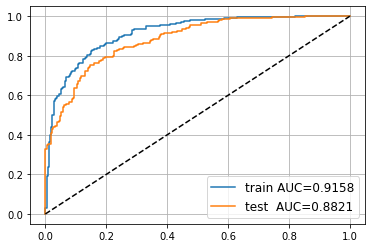

In [47]:
gensim_model = LogisticRegression().fit(texts_train_gensim_twit, y_train)

for name, X, y, model in [
    ('train', texts_train_gensim_twit, y_train, gensim_model),
    ('test ', texts_test_gensim_twit, y_test, gensim_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

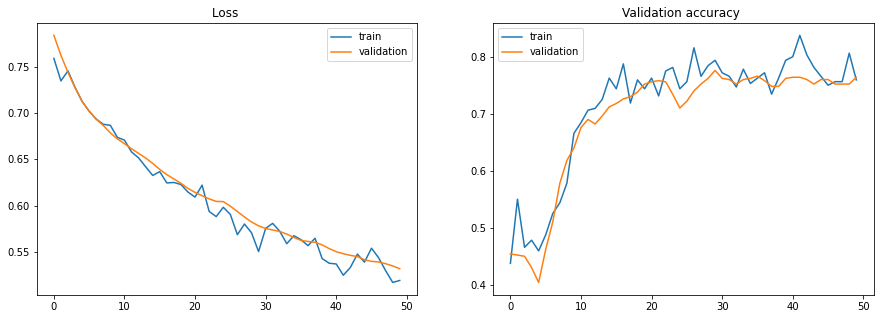

In [48]:
# инициализируем данные для pytorch
X_train_gensim_torch = torch.tensor(texts_train_gensim_twit)
X_test_gensim_torch = torch.tensor(texts_test_gensim_twit)

y_train_torch = torch.tensor(y_train)
y_test_torch = torch.tensor(y_test)

# посмотрим на реализацию логистической регрессии в Pytorch

# инициализируем модель
model_gen = nn.Sequential()
model_gen.add_module('l1', nn.Linear(X_train_gensim_torch.shape[1], 2))
# функция потерь
loss_function = nn.CrossEntropyLoss()
# с
opt = torch.optim.Adam(model_gen.parameters())
lr_scheduler = ReduceLROnPlateau(opt, patience=35)
gensim_nn_model = train_model(model_gen, opt, lr_scheduler, X_train_gensim_torch, y_train_torch, X_test_gensim_torch, y_test_torch)

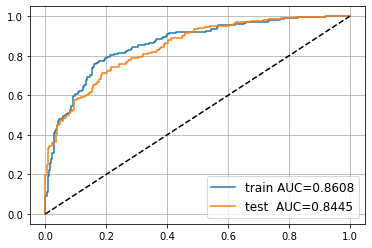

In [49]:
for name, X, y, model in [
    ('train', X_train_gensim_torch, y_train_torch, gensim_nn_model),
    ('test ', X_test_gensim_torch, y_test_torch, gensim_nn_model)
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Использование предобученной модели на твитах дает очень не плохие результаты, даже на малом наборе данных, плюс переобучения не наблюдается.